In [1]:
%load_ext autoreload
%autoreload 2


>> Import Libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import datetime
import seaborn as sns
from scipy.stats import chi2_contingency, beta
import plotly.graph_objs as go

from scipy.stats import binom, beta, stats

>> Import required modules

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from plot import Plot

>> Initialize plot class

In [4]:
pl = Plot()

>> Ignoring warnings

In [5]:
import warnings
warnings.filterwarnings('ignore')


>> Load the data

In [62]:
dff = pd.read_csv('../data/AdSmartABdata.csv')

In [63]:
df = dff.copy()

In [64]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


Dropping the device_make column as it is not required for the analysis

In [66]:
df.drop('device_make', axis = 1, inplace=True)

In [67]:
df['experiment'] = np.where(df['experiment'] == 'control', 0, 1)

In [68]:
df['response'] = df.yes + df.no

In [69]:
df.drop(columns = ['yes', 'no'], axis = 1, inplace=True)

In [70]:
df['date'] = pd.to_datetime(df.date)

In [71]:
df.head()

,auction_id,experiment,date,hour,platform_os,browser,response
0,0008ef63-77a7-448b-bd1e-075f42c55e39,1,2020-07-10,8,6,Chrome Mobile,0
1,000eabc5-17ce-4137-8efe-44734d914446,1,2020-07-07,10,6,Chrome Mobile,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,1,2020-07-05,2,6,Chrome Mobile WebView,1
3,00187412-2932-4542-a8ef-3633901c98d9,0,2020-07-03,15,6,Facebook,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,0,2020-07-03,15,6,Chrome Mobile,0


In [72]:
df.date.min(), df.date.max()


(Timestamp('2020-07-03 00:00:00'), Timestamp('2020-07-10 00:00:00'))

In [73]:
df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)

In [74]:
df.drop('date', axis = 1, inplace = True)

In [75]:
df.groupby('browser').count()['auction_id']

browser
Android                          1
Chrome                           3
Chrome Mobile                 4554
Chrome Mobile WebView         1489
Chrome Mobile iOS               51
Edge Mobile                      1
Facebook                       764
Firefox Mobile                   1
Mobile Safari                  337
Mobile Safari UI/WKWebView      44
Opera Mini                       1
Opera Mobile                     3
Pinterest                        3
Puffin                           1
Samsung Internet               824
Name: auction_id, dtype: int64

In [76]:
df['chrome'] = df['browser'].apply(lambda x: int('Chrome' in x))

In [77]:
df['samsung'] = df['browser'].apply(lambda x: int('Samsung' in x))
df['facebook'] = df['browser'].apply(lambda x: int('Facebook' in x))
df['safari'] = df['browser'].apply(lambda x: int('Safari' in x))

In [78]:
df.drop('browser', axis = 1, inplace=True)

>> #### Classical approach of AB Testing

>> Question: Does the Smart add (experiment = 1) show an improvement in user engagement (response rate)

    Null Hypothesis:
                    H0: there is no difference in brand awareness between the exposed and control groups
           

    Alt Hypothesis:  H1: there is a difference in brand awareness between the exposed and control groups


Method: Binomial test

Threshold or significance level: 0.05

In [94]:
# Experiment 1:

control_conversion = dff[(dff['experiment'] == 'control') & (dff['yes'] == 1)].shape[0] / dff[(dff['experiment'] == 'control')].shape[0]
treatment_conversion = dff[(dff['experiment'] == 'exposed') & (dff['yes'] == 1)].shape[0] / dff[(dff['experiment'] == 'exposed')].shape[0]
lift = (treatment_conversion - control_conversion) / control_conversion


print(f"control conversion percentage: {round(control_conversion * 100, 2)}%")
print(f"Treatment conversion percentage: {round(treatment_conversion * 100, 2)}%")
print(f"Lift percentage: {round(lift * 100, 2)}%")

control conversion percentage: 6.48%
Treatment conversion percentage: 7.69%
Lift percentage: 18.56%


In [95]:
# Create Contngency Table for chi square test
control_converted = dff[(dff['experiment'] == 'control') & (dff['yes'] == 1)].shape[0]
treatment_converted = dff[(dff['experiment'] == 'exposed') & (dff['yes'] == 1)].shape[0]
control_non_converted = dff[(dff['experiment'] == 'control') & (dff['no'] == 1)].shape[0]
treatment_not_converted = dff[(dff['experiment'] == 'exposed') & (dff['no'] == 1)].shape[0]

contingency_table = np.array([[control_converted, control_non_converted], [treatment_converted,         treatment_not_converted]])

In [96]:
contingency_table

array([[264, 322],
       [308, 349]])

In [97]:
chi, p_value, _, _ = chi2_contingency(contingency_table, correction=False)

In [98]:
chi, p_value

(0.41690289642162887, 0.518486498219898)

Since the p_value > 0.05, we cannot reject null hypothesis. Hence, we cannot conclude if there exists a relationship between the control and treatment groups.

In [99]:
print(f"{round(p_value * 100, 2)}% probability that a more extreme chi square than {round(chi, 3)} would have occured by chance")

51.85% probability that a more extreme chi square than 0.417 would have occured by chance


In [79]:
df.head()

,auction_id,experiment,hour,platform_os,response,dayofweek,chrome,samsung,facebook,safari
0,0008ef63-77a7-448b-bd1e-075f42c55e39,1,8,6,0,4,1,0,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,1,10,6,0,1,1,0,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,1,2,6,1,6,1,0,0,0
3,00187412-2932-4542-a8ef-3633901c98d9,0,15,6,0,4,0,0,1,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,0,15,6,0,4,1,0,0,0


In [80]:
control_response_rate = np.sum(df[df.experiment == 0]['response'])/len(df[df.experiment == 0])

In [81]:
control_response_rate

0.14394497666421027

In [82]:
exposure_response_rate = np.sum(df[df.experiment == 1]['response'])/len(df[df.experiment == 1])
exposure_response_rate

0.16400399400898652

In [86]:
df[df.experiment == 1]['response']

0       0
1       0
2       1
8       0
13      0
       ..
8065    0
8067    0
8071    1
8072    0
8075    0
Name: response, Length: 4006, dtype: int64

In [83]:
num_exposure_responses = np.sum(df[df.experiment == 1]['response'])
num_exposure_responses


657

In [84]:

null_dist = binom(n = len(df[df.experiment == 1]), p = control_response_rate)

In [85]:
p_val = 1 - null_dist.cdf(num_exposure_responses)
p_val

0.00017325902905473978

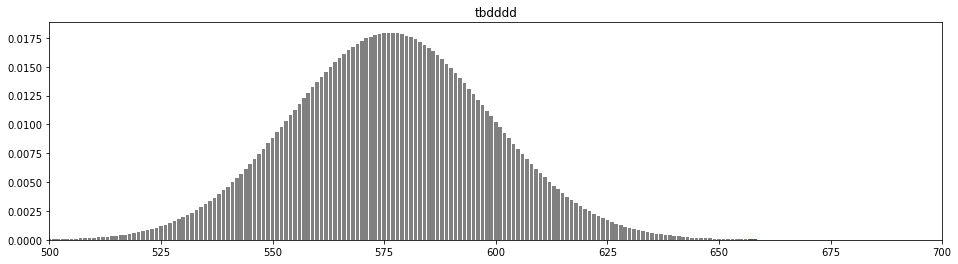

In [40]:
fig, ax = plt.subplots(1, figsize=(16, 4))
bars = ax.bar(range(675), [null_dist.pmf(i) for i in range(675)], align="center", color="grey")
ax.set_xlim(500, 700)
ax.set_title("tbdddd")

for i in range(num_exposure_responses,675):
    bars[i].set_color('red')

In [57]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [89]:
dff['exp'] = dff.experiment.apply(lambda x: 0 if x == 'control' else 1)

In [91]:
dff.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,exp
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0,1
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0,1
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0,0


In [92]:
dff2 = dff.copy()

In [ ]:
dff2.drop('experiment', axis = 1, inplace = True)